**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [6]:
print(raw_data.shape)

(10886, 12)


In [7]:
raw_data.isnull().values.any()

False

### Предобработка данных

#### Типы признаков

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [9]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [10]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [11]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


#### Обучение и отложенный тест

In [12]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [13]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [14]:
print('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

In [15]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [16]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Целевая функция на обучающей выборке и на отложенном тесте

Text(0.5, 1.0, 'test data')

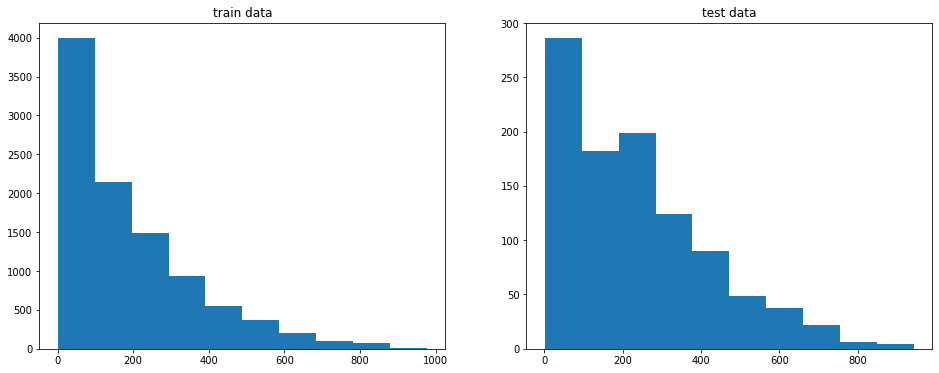

In [17]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Числовые признаки

In [18]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [19]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [20]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [21]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Модель

In [22]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter=10)
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 10,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [23]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

33433259713821.977

In [24]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [25]:
print(regressor.predict(test_data)[:10])

[7.26230653e+13 1.12792024e+14 4.91827699e+13 2.98993590e+13
 3.10090875e+13 4.32781604e+13 4.36795042e+13 3.96626564e+13
 4.55821647e+13 5.85758300e+13]


In [26]:
regressor.coef_

array([ 4.58087435e+10, -2.55862391e+10,  4.85732241e+10,  1.06950178e+10,
        9.14819487e+10,  1.32511185e+11,  3.18258902e+10, -5.11688043e+09])

### Scaling

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
#создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [29]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.07615904335670785

In [30]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [31]:
print(regressor.predict(scaled_test_data)[:10])

[524.87619388 834.8698777  354.90701298 221.9371283  227.90519711
 324.92932987 327.93992947 307.96674448 345.94404347 445.94127744]


### Подозрительно хорошо?

In [32]:
print(regressor.coef_)

[ 9.04149427e-01 -8.97279375e-01  5.89642328e-03 -2.75492540e-02
  5.08586077e+01  1.48008130e+02 -3.23564972e-03  7.73478887e-03]


In [33]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

[0.9, -0.9, 0.01, -0.03, 50.86, 148.01, -0.0, 0.01]


In [34]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [35]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14])

In [36]:
np.all(train_data.registered + train_data.casual == train_labels)

True

In [37]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [38]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [39]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.13062778728205

In [40]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

[32.92, 33.75, -44.55, 2.07, 14.55, 51.12]


### Pipeline

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [
    ('scaling', scaler), 
    ('regression', regressor)
])

In [43]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.13062778728205

### Подбор параметров

In [44]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [45]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [46]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [ ]:
%%time
grid_cv.fit(train_data, train_labels)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

### Оценка по отложенному тесту

In [ ]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

In [ ]:
np.mean(test_labels)

In [ ]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [ ]:
print(test_labels[:10])

In [ ]:
print(test_predictions[:10])

In [ ]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)